In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile
import statsmodels.api as sm

from scipy.stats import norm,t,truncnorm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import multivariate_t as mvt
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize
from scipy.stats import gaussian_kde as sciKDE

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as sklKDE

import warnings
warnings.filterwarnings("ignore")

In [2]:
class MLE:
    def __init__(self,dim,sigma):
        self.dim=dim
        self.T=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim))
        self.iP=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim),cov=sigma**2)
        self.iS=lambda size: mvnorm.rvs(size=size,mean=np.zeros(dim),cov=sigma**2)
        
    def __estimate(self,W,name):
        Z=np.mean(W)
        err=np.abs(Z-1)
        aVar=np.var(W)
        aErr=np.sqrt(aVar/W.size)
        print('{} est: {:.4f}; err: {:.4f}; a-var: {:.4f}; a-err: {:.4f}'.format(name,Z,err,aVar,aErr))
        
    def estimate_IS(self,size):
        S=self.iS(size)
        W=self.T(S)/self.iP(S)
        self.__estimate(W,'IS')
    
    def draw_TP(self,P,x,name,dim=0):
        X=np.zeros([x.size,self.dim])
        X[:,dim]=x
        ratio=np.reshape(self.T(np.zeros(self.dim))/P(np.zeros([1,self.dim])),1)[0]
        print('---------- pdf ratio at origin: {:.2f} ----------'.format(ratio))
        
        fig,ax=plt.subplots(figsize=(7,4))
        ax.plot(x,self.T(X))
        ax.plot(x,P(X))
        ax.legend(['target','{} proposal'.format(name)])
        ax.set_title('{}-D target and {} proposal (cross-sectional view)'.format(self.dim,name))
        plt.show()
        
    def resample(self,size,ratio):
        S=self.iS(ratio*size)
        p=self.T(S)/self.iP(S)
        index=np.arange(S.shape[0])
        choice=np.random.choice(index,size,p=p/np.sum(p),replace=True)
        
        self.rS=S[choice]
        self.rSset=S[list(set(choice))]
        print('resample rate: {}/{}'.format(self.rSset.shape[0],size))
        
    def estimate_NIS(self,size,rate,bdwth='scott'):
        if(type(bdwth)==str):
            tmp=sciKDE(self.rS.T,bw_method=bdwth)
            bdwth=np.mean(np.sqrt(np.diag(tmp.covariance_factor()*np.cov(self.rS.T))))
            print('bdwth: {:.4f}'.format(bdwth))
        
        self.bdwth=bdwth
        self.kde=sklKDE(kernel='gaussian',bandwidth=bdwth).fit(self.rS)
        
        self.nP=lambda x: np.exp(self.kde.score_samples(x))
        self.nS=lambda size: self.kde.sample(size)
        S=self.nS(size)
        W=self.T(S)/self.nP(S)
        self.__estimate(W,'NIS')
        
        self.mP=lambda x: (1-rate)*self.iP(x)+rate*self.nP(x)
        self.mS=lambda size: np.vstack([self.iS(size-round(rate*size)),self.nS(round(rate*size))])
        S=self.mS(size)
        W=self.T(S)/self.mP(S)
        self.__estimate(W,'MIS')
        
    def estimate_RIS(self,size,alpha):
        S=self.mS(size)
        h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=self.bdwth**2)
        X=((np.array([h(S,loc) for loc in self.rSset])-self.iP(S))/self.mP(S)).T
        y=self.T(S)/self.mP(S)
        regO=Linear().fit(X,y)
        regL=Lasso(alpha).fit(X,y)
        print('R2(O): {:.4f}; intercept: {:.4f}; err: {:.4f}'.format(regO.score(X,y),regO.intercept_,np.abs(regO.intercept_-1)))
        print('R2(L): {:.4f}; intercept: {:.4f}; err: {:.4f}'.format(regL.score(X,y),regL.intercept_,np.abs(regL.intercept_-1)))
        
        newS=self.mS(size)
        newX=((np.array([h(newS,loc) for loc in self.rSset])-self.iP(newS))/self.mP(newS)).T
        newy=self.T(newS)/self.mP(newS)
        W=newy-newX.dot(regO.coef_)
        self.__estimate(W,'RIS(O)')
        W=newy-newX.dot(regL.coef_)
        self.__estimate(W,'RIS(L)')
        return X,y

IS est: 1.0289; err: 0.0289; a-var: 18.1387; a-err: 0.0426
---------- pdf ratio at origin: 128.00 ----------


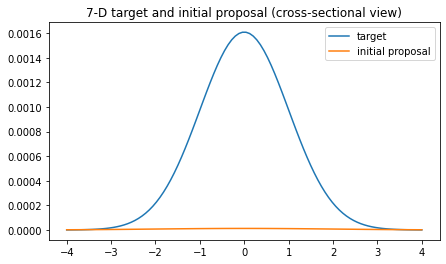

resample rate: 729/1000
bdwth: 0.7445
NIS est: 0.9988; err: 0.0012; a-var: 0.8433; a-err: 0.0092
MIS est: 1.0107; err: 0.0107; a-var: 1.0174; a-err: 0.0101
---------- pdf ratio at origin: 6.01 ----------


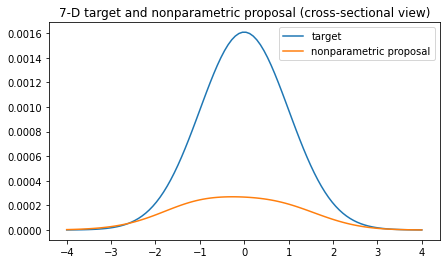

---------- pdf ratio at origin: 6.65 ----------


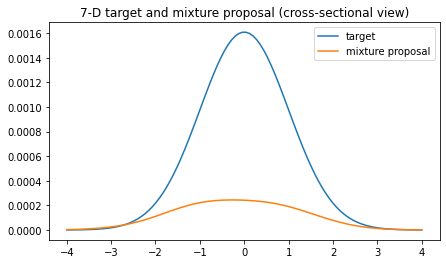

R2(O): 0.9258; intercept: 1.0042; err: 0.0042
R2(L): 0.8772; intercept: 1.0066; err: 0.0066
RIS(O) est: 1.0018; err: 0.0018; a-var: 0.0888; a-err: 0.0030
RIS(L) est: 1.0017; err: 0.0017; a-var: 0.1374; a-err: 0.0037


In [3]:
np.random.seed(1997)
mle=MLE(dim=7,sigma=2)
mle.estimate_IS(10000)
x=np.linspace(-4,4,100)
mle.draw_TP(mle.iP,x,'initial')
print('==================================================')
mle.resample(1000,20)
mle.estimate_NIS(10000,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
mle.draw_TP(mle.mP,x,'mixture')
print('==================================================')
X,y=mle.estimate_RIS(10000,0.1)